In [1]:
from data.mimic_preprocessing import *
#from local_face.local_face import *
#from local_face.helpers.plotters import *
#from local_face.helpers.datasets import *
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_auc_score
import time
import warnings
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [8]:
warnings.filterwarnings("ignore")

graph = True  # plotting
scale = True  # stanardised input data
bandwidth_search = False  # search for optimal bandwidth

# parameters for locating counterfactual and path
k = 50
thresh = 0.75
dist = 1
seed = 2
method_type = 'strict'
prob_dense = 1*10**(-12)
target = 1

# optionally, choose the type of factual:
# 'FN', 'FP', 'TN', 'TP' or 'all_neg' for TN+FP
factual_type = 'TN'

if factual_type == 'FP' or factual_type == 'TP':
    target = 0

# Extract top n
top_n_features = 5

# parameters for density model creation

features = ['airway', 'fio2', 'spo2_min',
            'hco3', 'resp_min', 'resp_max',
            'bp_min', 'hr_min', 'hr_max', 'pain',
            'gcs_min', 'temp_min', 'temp_max',
            'haemoglobin', 'k', 'na', 'creatinine', 'bun',
            'bmi', 'los', 'age', 'sex'
            ]


In [9]:

# import rfd testset data
X_train, y_train = load_dataset('mimic',
                                features,
                                scale=scale,
                                test=False
                                )
X_test, y_test = load_dataset('mimic',
                              features,
                              scale=scale
                              )

if bandwidth_search:
    grid = GridSearchCV(KernelDensity(kernel='tophat'),
                        {'bandwidth': np.linspace(0.00001, 0.001, 1000)},
                        cv=20)  # 20-fold cross-validation
    grid.fit(X_train)
    print(grid.best_params_)
    band_width = grid.best_params_['bandwidth']
else:
    band_width = 0.0000001

all_columns = X_train.columns

# trained random forest model
if scale:
    model = pickle.load(
        open(
            'rfd_model/rfd_model_combined_standardscale.pickle',
            'rb'
        ))
else:
    model = pickle.load(open('rfd_model/rf.pickle', 'rb'))

# sanity check that AUC performance matches expectation
result = roc_auc_score(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1])
print(f'Test set AUC performance {result:.3f}')

Test set AUC performance 0.882


In [13]:
import shap

ModuleNotFoundError: No module named 'shap'

In [10]:
# ---- select factual ----
factual = factual_selector('mimic', features, model,
                           seed=seed, scale=scale, alignment=factual_type)

1    1443
0    1363
Name: y_true, dtype: int64
In total there are 930 TN cases
Randomly selected TN case: 
        airway      fio2  spo2_min     hco3  resp_min  resp_max    bp_min  \
712  1.756151 -0.162449  1.395898  1.11216  0.103874 -0.838555  0.891544   

       hr_min    hr_max      pain  ...         k        na  creatinine  \
712  0.047202 -0.227046 -0.604484  ... -0.085533  1.161478   -0.509408   

          bun       bmi       los       age       sex  y_true  y_pred  
712 -0.187791  0.008201 -0.015671 -0.350284  1.088614       0       0  

[1 rows x 24 columns]
Index(['airway', 'fio2', 'spo2_min', 'hco3', 'resp_min', 'resp_max', 'bp_min',
       'hr_min', 'hr_max', 'pain', 'gcs_min', 'temp_min', 'temp_max',
       'haemoglobin', 'k', 'na', 'creatinine', 'bun', 'bmi', 'los', 'age',
       'sex', 'y_true', 'y_pred'],
      dtype='object')


In [11]:
def shap_explain(factual):
    print(factual)

In [12]:
shap_explain(factual)

[ 1.75615079 -0.16244914  1.3958983   1.11216043  0.10387384 -0.83855487
  0.8915443   0.04720221 -0.22704593 -0.60448357 -1.90778587  2.89922689
  3.35770072 -0.43410605 -0.08553341  1.16147766 -0.50940751 -0.18779133
  0.00820142 -0.01567076 -0.35028441  1.08861412]


Test set AUC performance 0.882
1    1443
0    1363
Name: y_true, dtype: int64
In total there are 930 TN cases
Randomly selected TN case: 
        airway      fio2  spo2_min     hco3  resp_min  resp_max    bp_min  \
712  1.756151 -0.162449  1.395898  1.11216  0.103874 -0.838555  0.891544   

       hr_min    hr_max      pain  ...         k        na  creatinine  \
712  0.047202 -0.227046 -0.604484  ... -0.085533  1.161478   -0.509408   

          bun       bmi       los       age       sex  y_true  y_pred  
712 -0.187791  0.008201 -0.015671 -0.350284  1.088614       0       0  

[1 rows x 24 columns]
Index(['airway', 'fio2', 'spo2_min', 'hco3', 'resp_min', 'resp_max', 'bp_min',
       'hr_min', 'hr_max', 'pain', 'gcs_min', 'temp_min', 'temp_max',
       'haemoglobin', 'k', 'na', 'creatinine', 'bun', 'bmi', 'los', 'age',
       'sex', 'y_true', 'y_pred'],
      dtype='object')
--- processing for feature age ---
scaled allowable age range -0.8552258245023482 to 0.15465700393838713
--- pr

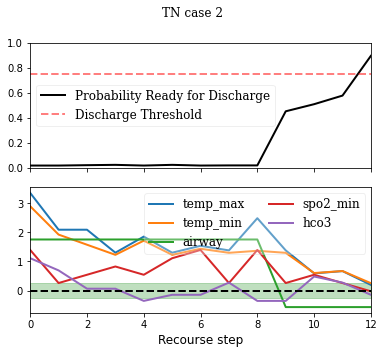

0
1
2
3
4


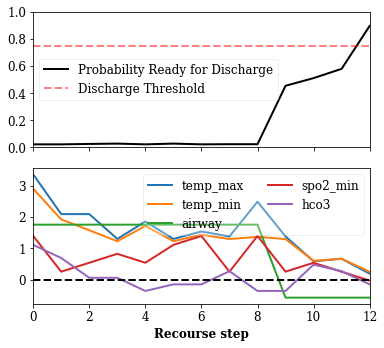

Top features to track between examples:
factual info: 
certainty 0.021609411936066473
feats: airway           1.0000
fio2            40.0000
spo2_min       100.0000
hco3            31.0000
resp_min        16.0000
resp_max        18.0000
bp_min         133.0000
hr_min          80.0000
hr_max          87.0000
pain             0.0000
gcs_min          7.0000
temp_min        39.1111
temp_max        39.2222
haemoglobin      9.4000
k                4.0000
na             145.0000
creatinine      53.0520
bun              7.8562
bmi             31.5850
los            107.1390
age             53.0000
sex              1.0000
Name: 0, dtype: float64
instance 1 with RFD certainty 0.021609411936066473
na          7.0000
temp_max    0.8889
spo2_min    4.0000
k           0.6000
temp_min    0.7778
dtype: float64
instance 2 with RFD certainty 0.024591692279514653
bp_min      24.0
hr_min      14.0
fio2        10.0
hr_max      12.0
resp_max     4.0
dtype: float64
instance 3 with RFD certainty 0.02715900111

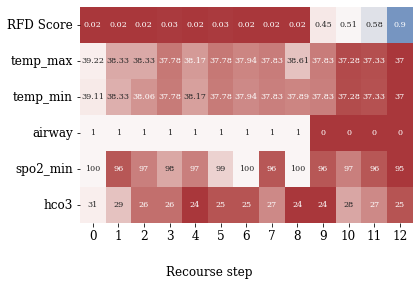

<Figure size 432x288 with 0 Axes>

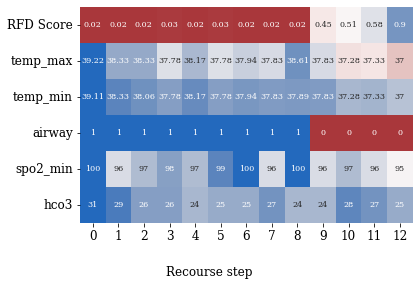

<Figure size 432x288 with 0 Axes>

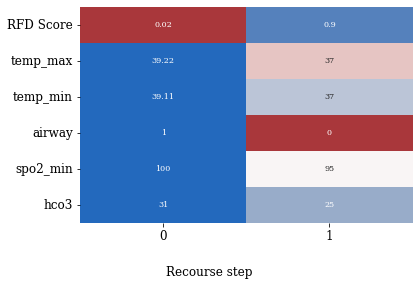

In [1]:


# train density estimator using training data
X_train_den = np.array(X_train)
dense = KernelDensity(kernel='tophat', bandwidth=band_width).fit(X_train_den)

# how far from the current value we allow a change in age
age_range = 25  # years
los_range = 300  # days

if scale:
    age_lower, age_higher = feature_constrain_range(
        factual, features, 'age', age_range)
    los_lower, los_higher = feature_constrain_range(
        factual, features, 'los', los_range)

else:
    age_lower = factual['age'] - age_range
    age_higher = factual['age'] + age_range
    los_lower = factual['los'] - los_range
    los_higher = factual['los'] + los_range

# print('age range_lower', age_lower, 'age range_higher', age_higher)

# optionally constrain available datapoints to variables of interest
upper_age = ">"+str(age_higher)
lower_age = "<"+str(age_lower)
upper_los = ">"+str(los_higher)
lower_los = "<"+str(los_lower)
constraints = [
    [],  # 'airway'
    [],  # 'fio2',
    [],  # 'spo2_min',
    [],  # 'hco3',
    [],  # 'resp_min',
    [],  # 'resp_max',
    [],  # 'bp_min',
    [],  # 'hr_min', ["<45"], [">55"]
    [],  # 'hr_max',
    [],  # 'pain',
    [],  # 'gcs_min',
    [],  # 'temp_min',
    [],  # 'temp_max',
    [],  # 'haemoglobin',
    [],  # 'k',
    [],  # 'na',
    [],  # 'creatinine',
    [],  # 'bun',
    [],  # 'bmi',
    [],  # [upper_los, lower_los],  # 'los',
    [upper_age, lower_age],  # 'age',
    ['!=' + str(factual[21])],  # 'sex'
]

X_train = constrain_search(X_train, constraints)
X_test = constrain_search(X_test, constraints)


# y = np.ravel(y)
X_train = np.array(X_train)


start_total = time.time()

# initialise Local-FACE model
face = LocalFace(X_train, model, dense)  # constrained

# find a counterfactual
print(r"Finding counterfactual x' (explore)...")
start_explore = time.time()
steps, cf = face.find_cf(factual, k=k, thresh=thresh, mom=0, target=target)
print('Explore time taken: {} seconds'.format(
    np.round(time.time() - start_explore, 2)))
overall_recourse = pd.DataFrame([factual - cf], columns=features)
print('---------------------------------')

# generate graph nodes through data from factual to counterfactual
print(r'Creating graph G (Exploit)...')
start_exploit = time.time()
best_steps, G = face.generate_graph(
    factual, cf, k, thresh, prob_dense, 10, early=True, method=method_type, target=target)
# create edges between viable points and calculate the weights
"""prob = face.dense.score([factual])
G = face.create_edges(1, 10, method='strict')"""
print('Exploit time taken: {} seconds'.format(
    np.round(time.time() - start_exploit, 2)))
print('---------------------------------')


# calculate shortest path through G from factual to counterfactual
print(r"Finding shortest path from x to x' through G (Enhance)...")
start_enhance = time.time()
shortest_path = face.shortest_path(method=method_type)
print('Enhance time taken: {} seconds'.format(
    np.round(time.time() - start_enhance, 2)))
print('---------------------------------')
print('Total time taken: {} seconds'.format(
    np.round(time.time() - start_total, 2)))


# Create dataframe of path
path_df = pd.DataFrame(best_steps, columns=features)
# linear distance
lin_dist = np.linalg.norm(best_steps[0] - best_steps[-1])
# total distance
tot_dist = 0
for i in range(1, len(best_steps)):
    tot_dist += np.linalg.norm(best_steps[i] - best_steps[i-1])
print('Deviation Factor (linear distance/total distance): {}'.format(lin_dist/tot_dist))

# And copy in the original unscaled space
path_df_inversed_scaling = inverse_scaling(path_df, features)

print('Path in unscaled units', path_df_inversed_scaling)


# Find most relevant / changing / volatile features to display
# Identify features with largest std
features_std = path_df.std().sort_values(ascending=False)[0:top_n_features]
# Absolute largest change in feature value between factual and counterfactual
features_abs = (path_df.iloc[0] - path_df.iloc[-1]
                ).sort_values(ascending=False)[0:top_n_features]
print(f'Top {top_n_features} features which vary: \n', features_std)
# Then extract features to list
volatile_feats = features_std.index.values
abs_feats = features_abs.index.values

# Then extract these relevant columns from the path dataframe (combined)
volatile_combined = path_df[volatile_feats]
abs_combined = path_df[abs_feats]

print('Top features to track overall: \n', volatile_combined)
print('Unscaled top features:', path_df_inversed_scaling[volatile_feats])

unscaled_abs_combined = path_df_inversed_scaling[abs_feats]

safe_bound = 0.25


if graph:
    # Plot probabilites over the path, scaled, with "healthy" region
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5.5, 5))
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    probs = model.predict_proba(best_steps)
    rfd_probs = [item[1] for item in probs]
    line_width = 2
    if factual_type == 'FP' or factual_type == 'TP':
        ax[0].plot(rfd_probs, '-k',
                   label=('Probability Not Ready for Discharge'),
                   linewidth=line_width)
    else:
        ax[0].plot(rfd_probs, '-k',
                   label=('Probability Ready for Discharge'),
                   linewidth=line_width)
    if factual_type == 'FP' or factual_type == 'TP':
        thresh = 1 - thresh
    ax[0].axhline(thresh, color='red', linestyle='--',
                  linewidth=line_width, alpha=0.5, label='Discharge Threshold')
    ax[0].legend(fancybox=True, framealpha=0.3)
    ax[0].set_ylim([0, 1])
    num_inst = len(path_df.index)
    ind_inst = np.arange(0, num_inst)
    for i in range(top_n_features):
        print(i)
        ax[1].plot(ind_inst, abs_combined.iloc[:, i],
                   label=str(list(abs_combined.columns.values)[i]), linewidth=line_width)
    ax[1].legend(framealpha=0.3,
                 fancybox=True, ncol=2)
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlim([0, num_inst-1])
    ax[1].axhline(0, color='black', linestyle='--', linewidth=line_width)
    x_fill = np.arange(0, len(abs_combined))
    ax[1].fill_between(x=x_fill, y1=safe_bound, y2=-safe_bound, color='green',
                       interpolate=True, alpha=.25)
    ax[1].set_xlabel('Recourse step', fontsize=12)
    plt.suptitle(f'{factual_type} case {seed}')
    plt.tight_layout()
    plt.savefig(
        "local_face/plots/RFD/RFD_{}_feats{}_seed{}_safe_bound.pdf".format(factual_type, top_n_features, seed))
    plt.show()


if graph:
    # Plot probabilites over the path
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5.5, 5))
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    probs = model.predict_proba(best_steps)
    rfd_probs = [item[1] for item in probs]
    line_width = 2
    if factual_type == 'FP' or factual_type == 'TP':
        ax[0].plot(rfd_probs, '-k',
                   label=('Probability Not Ready for Discharge'),
                   linewidth=line_width)
    else:
        ax[0].plot(rfd_probs, '-k',
                   label=('Probability Ready for Discharge'),
                   linewidth=line_width)
    if factual_type == 'FP' or factual_type == 'TP':
        thresh = 1 - thresh
    ax[0].axhline(thresh, color='red', linestyle='--',
                  linewidth=line_width, alpha=0.5, label='Discharge Threshold')
    ax[0].legend(fancybox=True, framealpha=0.3)
    ax[0].set_ylim([0, 1])
    num_inst = len(path_df.index)
    ind_inst = np.arange(0, num_inst)
    for i in range(top_n_features):
        print(i)
        ax[1].plot(ind_inst, abs_combined.iloc[:, i],
                   label=str(list(abs_combined.columns.values)[i]), linewidth=line_width)
    ax[1].legend(framealpha=0.3,
                 fancybox=True, ncol=2)
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlim([0, num_inst-1])
    ax[1].axhline(0, color='black', linestyle='--', linewidth=line_width)
    '''
    for i in range(top_n_features):
        print(i)
        ax[2].plot(ind_inst, volatile_combined.iloc[:, i],
                   label=str(list(volatile_combined.columns.values)[i]), linewidth=0.5)
    ax[2].legend(framealpha=0.3, fancybox=True, ncol=top_n_features)
    ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlim([0, num_inst-1])
    ax[2].axhline(0, color='black', linestyle='--', linewidth='0.75')
    '''
    ax[1].set_xlabel('Recourse step', fontsize=12)
    # plt.suptitle(f'{factual_type} case {seed}')
    plt.tight_layout()
    plt.savefig(
        "local_face/plots/RFD/RFD_{}_feats{}_seed{}.pdf".format(factual_type, top_n_features, seed))
    plt.show()


print('Top features to track between examples:')
print('factual info: ')
print('certainty {}'.format(model.predict_proba(
    [np.array(path_df.iloc[0])])[0, 1]))
print('feats: {}'.format(inverse_scaling(path_df, features).iloc[0]))
for i in range(1, len(path_df.index)):
    print('instance {} with RFD certainty {}'.format(
        i, model.predict_proba([np.array(path_df.iloc[i])])[0, 1]))
    inst = path_df.iloc[i-1:i+1]
    temp = (inst.iloc[0] - inst.iloc[1]
            ).sort_values(ascending=False)[0:top_n_features]
    volatile_feats = temp.index.values

    path_df_inversed_scaling = inverse_scaling(path_df, features)
    # Then extract these relevant columns from the path dataframe (combined)
    volatile_combined = path_df_inversed_scaling.iloc[i-1][volatile_feats] - \
        path_df_inversed_scaling.iloc[i][volatile_feats]
    print(volatile_combined)


# Heatmap of feature changes over the path
# Transpose dataframe so that columns are the recourse steps
# Plotted like this to use colour range independently for each row/feature


# to_plot options:
#    path_df_inversed_scaling -> all features
#    unscaled_abs_combined -> top n features with the largest relative change
#         from factual to counterfactual, based off the scaled range but then unscaled

# bounds for "healthy person"
centre_data = [0.5, 0.6, 95, 19, 10, 30, 100, 60, 100, 0.5,
               7, 36, 37.5, 90, 4.75, 140, 81.5, 5.15, 21, 3.5, 50, 0.5]

centres = pd.DataFrame([centre_data], columns=features)

to_plot = unscaled_abs_combined
to_plot.insert(0, "RFD Score", rfd_probs, True)

f, axs = plt.subplots(len(to_plot.T),
                      1, gridspec_kw={'hspace': 0})

counter = 0
for index, row in to_plot.T.iterrows():
    if counter == 0:
        centre = 0.5
    else:
        centre = row[0]
    sns.heatmap(
        np.array(np.round([row.values], 2)),
        yticklabels=[to_plot.columns[counter]],
        xticklabels=to_plot.T.columns,
        annot=True,
        ax=axs[counter],
        cbar=False,
        annot_kws={"fontsize": 8},
        robust=True,
        center=centre,
        cmap="vlag_r",
        fmt='g'
    )
    counter += 1

for ax in axs:
    ax.tick_params(axis='y', rotation=0)


# f.suptitle(f'{factual_type} case {seed}')
f.supxlabel('Recourse step')
# f.supylabel('Variable')
plt.tight_layout()
plt.subplots_adjust(left=0.2)
plt.savefig(
    "local_face/plots/RFD/heatmaps/RFD_heatmap_{}_seed{}_full.pdf".format(factual_type, seed))
plt.show()

plt.clf()

f, axs = plt.subplots(len(to_plot.T),
                      1, gridspec_kw={'hspace': 0})

counter = 0
for index, row in to_plot.T.iterrows():
    if counter == 0:
        centre = 0.5
    else:
        centre = centres[to_plot.columns[counter]][0]
    sns.heatmap(
        np.array(np.round([row.values], 2)),
        yticklabels=[to_plot.columns[counter]],
        xticklabels=to_plot.T.columns,
        annot=True,
        ax=axs[counter],
        cbar=False,
        robust=True,
        annot_kws={"fontsize": 8},
        center=centre,
        cmap="vlag_r",
        fmt='g'
    )
    counter += 1

for ax in axs:
    ax.tick_params(axis='y', rotation=0)


# f.suptitle(f'{factual_type} case {seed}')
f.supxlabel('Recourse step')
# f.supylabel('Variable')
plt.tight_layout()
plt.subplots_adjust(left=0.2)
plt.savefig(
    "local_face/plots/RFD/heatmaps/RFD_heatmap_{}_seed{}_full_healthybounds.pdf".format(factual_type, seed))
plt.show()

plt.clf()

# get first and last column
new_df = to_plot.iloc[[0, -1]]

f, axs = plt.subplots(len(new_df.T),
                      1, gridspec_kw={'hspace': 0})

counter = 0
for index, row in new_df.T.iterrows():
    if counter == 0:
        centre = 0.5
    else:
        centre = centres[to_plot.columns[counter]][0]
    sns.heatmap(
        np.array(np.round([row.values], 2)),
        yticklabels=[to_plot.columns[counter]],
        xticklabels=to_plot.T.columns[0:2],
        annot=True,
        ax=axs[counter],
        cbar=False,
        robust=True,
        annot_kws={"fontsize": 8},
        center=centre,
        cmap="vlag_r",
        fmt='g'
    )
    counter += 1

for ax in axs:
    ax.tick_params(axis='y', rotation=0)

# f.suptitle(f'{factual_type} case {seed}')
f.supxlabel('Recourse step')
# f.supylabel('Variable')
plt.tight_layout()
plt.subplots_adjust(left=0.2)
plt.savefig(
    "local_face/plots/RFD/heatmaps/RFD_heatmap_{}_seed{}_end.pdf".format(factual_type, seed))
plt.show()
